# Case Study: Florentine Families

Inspired by [this course by Mark Hoffman](https://bookdown.org/markhoff/social_network_analysis/centrality.html) and [this analysis by Nick](https://napsterinblue.github.io/notes/algorithms/graphs/centrality_measures/).

Part of the [Networks Science Course](https://github.com/chatox/networks-science-course/) at Universitat Pompeu Fabra, by [Carlos Castillo](https://chato.cl/).

Updated October 2022.

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

## 1. Load data

In [2]:
INPUT_FAMILIES = "florentine_attributes.csv"
INPUT_MARRIAGES = "florentine_marriage_edgelist.csv"
INPUT_CREDIT = "florentine_credit_edgelist.csv"
INPUT_PARTNERS = "florentine_partner_edgelist.csv"

In [3]:
# Families metadata

#  Gwealth is Gross wealth in Florins; NA are likely less wealthy than other families
#  Npriors is the aggregated number of seats in Florence's governing body
families = pd.read_csv(INPUT_FAMILIES, usecols=['Family', 'Gwealth', 'Npriors'])
families.Gwealth = families.Gwealth.fillna(0)
families.Npriors = families.Npriors.fillna(0)
families.set_index('Family', inplace=True)

print("Loaded metadata for %d families" % len(families))
families.head(5)

Loaded metadata for 116 families


,Gwealth,Npriors
Family,,
Acciaiuoli,28200.0,53.0
Adimari,45689.0,0.0
Alberti,0.0,38.0
Albizzi,92599.0,65.0
Aldobrandini,7171.0,27.0


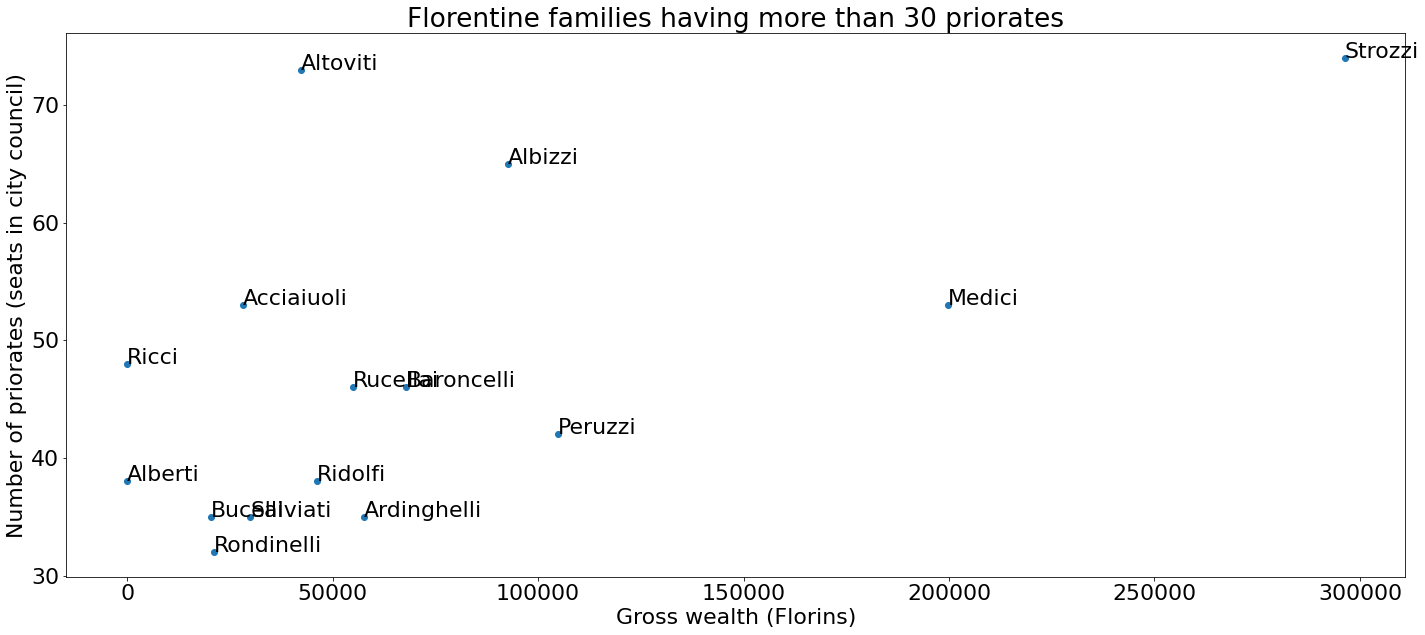

In [4]:
# Correlation of wealth and priorates exists but is weak

plt.rc('font', size=22) #controls default text size

MIN_PRIORS = 30

plt.figure(figsize=(24,10))
plt.scatter(families[families.Npriors > MIN_PRIORS].Gwealth, families[families.Npriors > MIN_PRIORS].Npriors)
plt.title("Florentine families having more than %d priorates" % MIN_PRIORS)
plt.xlabel("Gross wealth (Florins)")
plt.ylabel("Number of priorates (seats in city council)")
for idx, row in families.iterrows(): 
    if row['Npriors'] > MIN_PRIORS:
        plt.text(row['Gwealth'], row['Npriors'], idx)


In [5]:
print("Pearson correlation(wealth, priors): %.4f" % families.Gwealth.corr(families.Npriors, method='pearson'))

Pearson correlation(wealth, priors): 0.3932


# 2. Analyze marriages (undirected)

Nodes: 96, Edges: 157


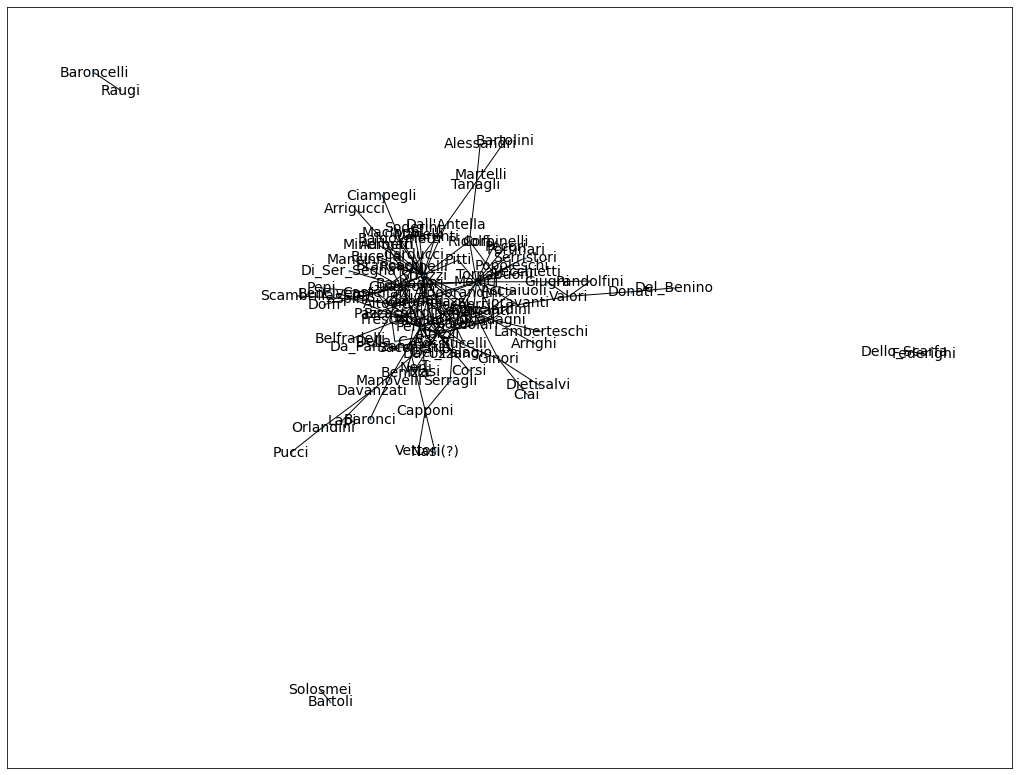

In [6]:
# Marriages

marriages_list = pd.read_csv(INPUT_MARRIAGES, usecols=['FamilyA', 'FamilyB'])

marriages = nx.from_pandas_edgelist(marriages_list, "FamilyA", "FamilyB")

plt.figure(figsize=(18,14))

nx.draw_networkx(marriages, node_size=1, font_size=14)

print("Nodes: %d, Edges: %d" % (marriages.number_of_nodes(), marriages.number_of_edges()))

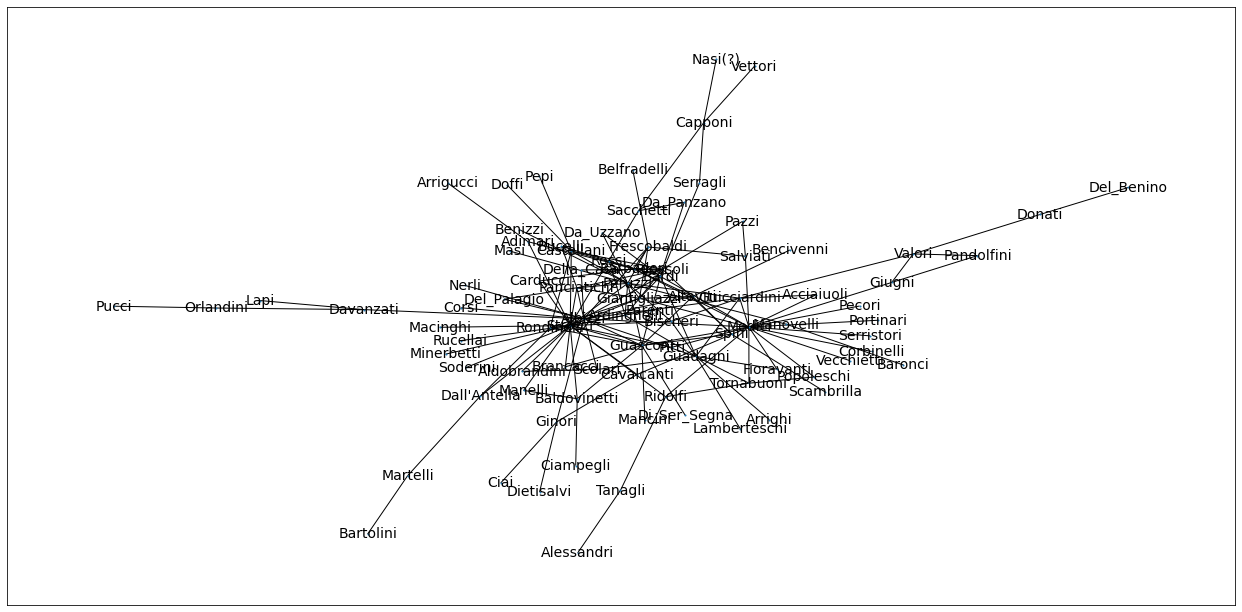

In [7]:
# Extract giant connected component

marriages_components = sorted(nx.connected_components(marriages), key=len, reverse=True)
marriages_gcc = marriages.subgraph(marriages_components[0])

plt.figure(figsize=(22,11))
nx.draw_networkx(marriages_gcc, node_size=1, font_size=14)

In [8]:
print("Nodes in giant connected component: %d (%.2f%%)" % (marriages_gcc.number_of_nodes(),
                                                           100*marriages_gcc.number_of_nodes()/marriages.number_of_nodes()))

Nodes in giant connected component: 90 (93.75%)


In [9]:
# Compute degree

m_degree = pd.DataFrame(marriages_gcc.degree(), columns=['Family', 'm_degree'])
m_degree.set_index('Family', inplace=True)
families = families.join(m_degree, how='inner')
display(families.head(5))

,Gwealth,Npriors,m_degree
Family,,,
Acciaiuoli,28200.0,53.0,2
Adimari,45689.0,0.0,3
Albizzi,92599.0,65.0,14
Aldobrandini,7171.0,27.0,2
Alessandri,0.0,2.0,1


In [10]:
# Degree of some nodes (checking)

print(families.loc[['Peruzzi', 'Medici', 'Strozzi']].m_degree)

Family
Peruzzi    15
Medici     20
Strozzi    25
Name: m_degree, dtype: int64


In [11]:
# Compute closeness

m_closeness = pd.DataFrame.from_dict(nx.closeness_centrality(marriages_gcc), orient='index', columns=['m_closeness'])
families = families.join(m_closeness, how='inner')
display(families.head(5))

,Gwealth,Npriors,m_degree,m_closeness
Acciaiuoli,28200.0,53.0,2,0.321300
Adimari,45689.0,0.0,3,0.342308
Albizzi,92599.0,65.0,14,0.415888
Aldobrandini,7171.0,27.0,2,0.330855
Alessandri,0.0,2.0,1,0.217073


In [12]:
# Closeness of some nodes

print(families.loc[['Peruzzi', 'Medici', 'Strozzi']].m_closeness)

Peruzzi    0.423810
Medici     0.438424
Strozzi    0.456410
Name: m_closeness, dtype: float64


In [13]:
# Compute betweenness

m_betweenness = pd.DataFrame.from_dict(nx.betweenness_centrality(marriages_gcc), orient='index', columns=['m_betweenness'])
families = families.join(m_betweenness, how='inner')
display(families.head(5))

,Gwealth,Npriors,m_degree,m_closeness,m_betweenness
Acciaiuoli,28200.0,53.0,2,0.321300,0.000000
Adimari,45689.0,0.0,3,0.342308,0.023751
Albizzi,92599.0,65.0,14,0.415888,0.218702
Aldobrandini,7171.0,27.0,2,0.330855,0.005963
Alessandri,0.0,2.0,1,0.217073,0.000000


In [14]:
# Betweenness of some nodes

print(families.loc[['Peruzzi', 'Medici', 'Strozzi']].m_betweenness)

Peruzzi    0.154333
Medici     0.262924
Strozzi    0.349841
Name: m_betweenness, dtype: float64


In [15]:
# Compute eigenvector centrality

m_eigencentrality = pd.DataFrame.from_dict(nx.eigenvector_centrality(marriages_gcc), orient='index', columns=['m_eigencentrality'])
families = families.join(m_eigencentrality, how='inner')
display(families.head(5))

,Gwealth,Npriors,m_degree,m_closeness,m_betweenness,m_eigencentrality
Acciaiuoli,28200.0,53.0,2,0.321300,0.000000,0.055904
Adimari,45689.0,0.0,3,0.342308,0.023751,0.073158
Albizzi,92599.0,65.0,14,0.415888,0.218702,0.212622
Aldobrandini,7171.0,27.0,2,0.330855,0.005963,0.060300
Alessandri,0.0,2.0,1,0.217073,0.000000,0.001799


In [16]:
# Eigencentrality of some nodes

print(families.loc[['Peruzzi', 'Medici', 'Strozzi']].m_eigencentrality)

Peruzzi    0.316128
Medici     0.267879
Strozzi    0.399373
Name: m_eigencentrality, dtype: float64


In [17]:
corr = families.corr()
corr.style.background_gradient(cmap='Reds').format(precision=2)

,Gwealth,Npriors,m_degree,m_closeness,m_betweenness,m_eigencentrality
Gwealth,1.00,0.42,0.77,0.60,0.75,0.70
Npriors,0.42,1.00,0.57,0.45,0.59,0.51
m_degree,0.77,0.57,1.00,0.74,0.94,0.92
m_closeness,0.60,0.45,0.74,1.00,0.62,0.88
m_betweenness,0.75,0.59,0.94,0.62,1.00,0.79
m_eigencentrality,0.70,0.51,0.92,0.88,0.79,1.00


# 3. Analyze credit

Nodes: 72, Edges: 125


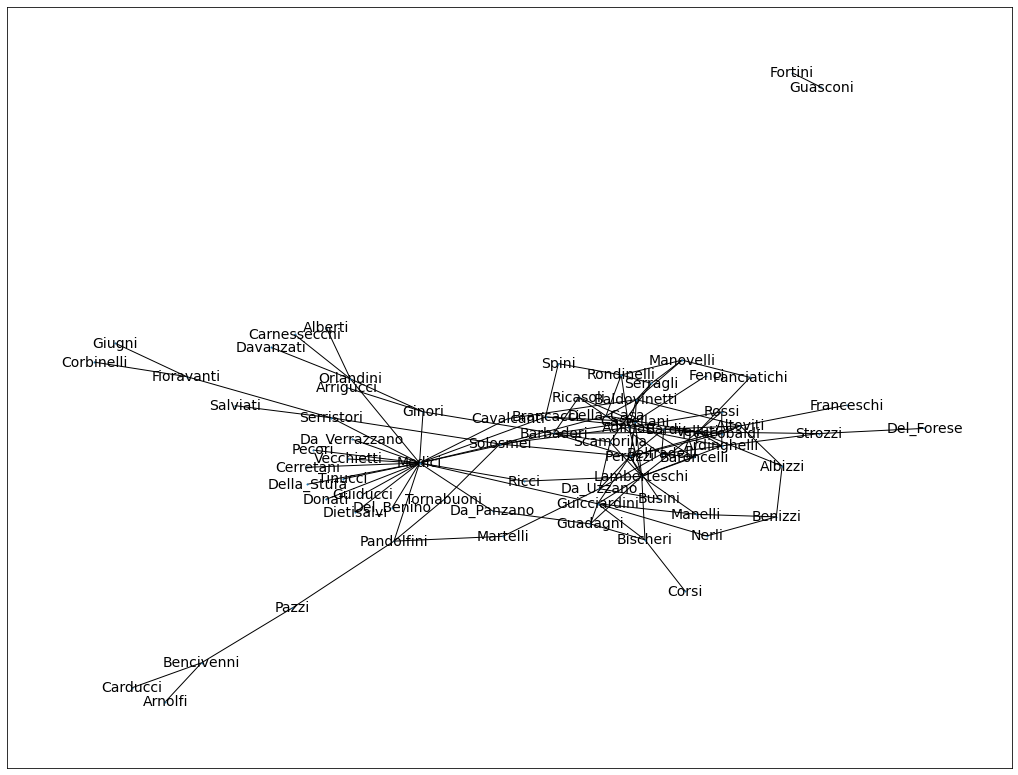

In [18]:
# Credits

credits_list = pd.read_csv(INPUT_CREDIT, usecols=['FamilyA', 'FamilyB'])

credits = nx.from_pandas_edgelist(credits_list, "FamilyA", "FamilyB")

plt.figure(figsize=(18,14))

nx.draw_networkx(credits, node_size=1, font_size=14)

print("Nodes: %d, Edges: %d" % (credits.number_of_nodes(), credits.number_of_edges()))

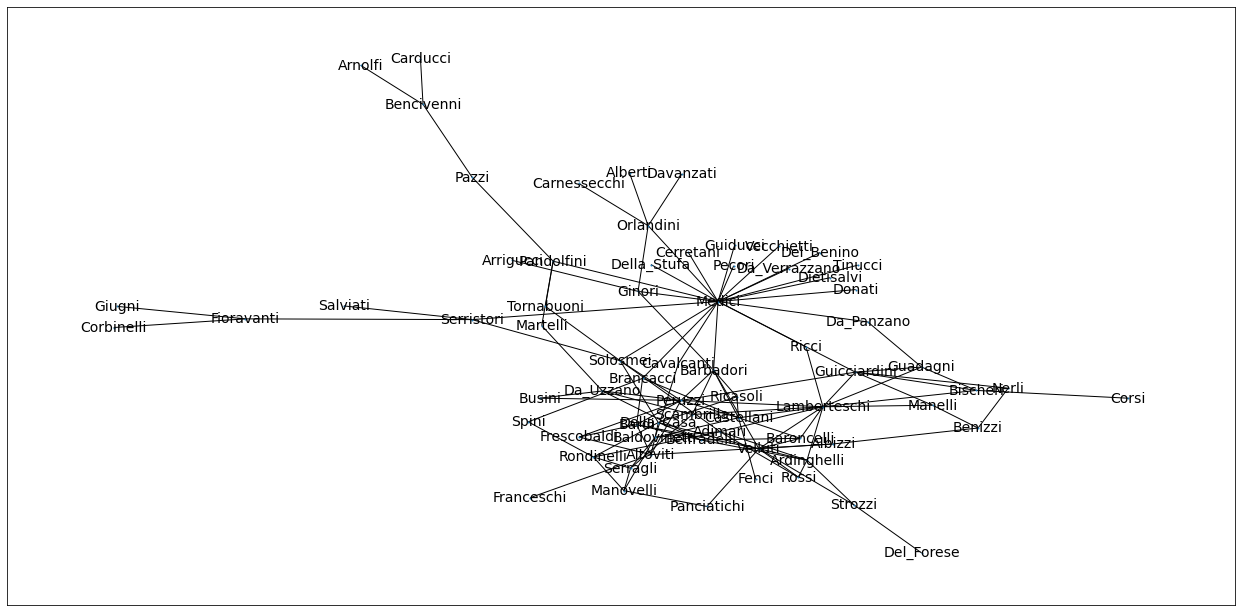

In [19]:
# Extract giant connected component

credits_components = sorted(nx.connected_components(credits), key=len, reverse=True)
credits_gcc = credits.subgraph(credits_components[0])

plt.figure(figsize=(22,11))
nx.draw_networkx(credits_gcc, node_size=1, font_size=14)

In [20]:
print("Nodes in giant connected component: %d (%.2f%%)" % (credits_gcc.number_of_nodes(),
                                                           100*credits_gcc.number_of_nodes()/credits.number_of_nodes()))

Nodes in giant connected component: 70 (97.22%)


In [21]:
# Compute degree

c_degree = pd.DataFrame(credits_gcc.degree(), columns=['Family', 'c_degree'])
c_degree.set_index('Family', inplace=True)
families = families.join(c_degree, how='inner')
display(families.head(5))

,Gwealth,Npriors,m_degree,m_closeness,m_betweenness,m_eigencentrality,c_degree
Adimari,45689.0,0.0,3,0.342308,0.023751,0.073158,6
Albizzi,92599.0,65.0,14,0.415888,0.218702,0.212622,3
Altoviti,42357.0,73.0,6,0.361789,0.032079,0.134690,6
Ardinghelli,57596.0,35.0,5,0.378723,0.014882,0.159790,6
Arrigucci,5736.0,0.0,1,0.255747,0.000000,0.009717,1


In [22]:
# Degree of some nodes (checking)

print(families.loc[['Peruzzi', 'Medici', 'Strozzi']].c_degree)

Peruzzi    10
Medici     21
Strozzi     3
Name: c_degree, dtype: int64


In [23]:
# Compute closeness

c_closeness = pd.DataFrame.from_dict(nx.closeness_centrality(credits_gcc), orient='index', columns=['c_closeness'])
families = families.join(c_closeness, how='inner')
display(families.head(5))


,Gwealth,Npriors,m_degree,m_closeness,m_betweenness,m_eigencentrality,c_degree,c_closeness
Adimari,45689.0,0.0,3,0.342308,0.023751,0.073158,6,0.363158
Albizzi,92599.0,65.0,14,0.415888,0.218702,0.212622,3,0.293617
Altoviti,42357.0,73.0,6,0.361789,0.032079,0.134690,6,0.313636
Ardinghelli,57596.0,35.0,5,0.378723,0.014882,0.159790,6,0.320930
Arrigucci,5736.0,0.0,1,0.255747,0.000000,0.009717,1,0.270588


In [24]:
# Closeness of some nodes (checking)

print(families.loc[['Peruzzi', 'Medici', 'Strozzi']].c_closeness)

Peruzzi    0.385475
Medici     0.475862
Strozzi    0.281633
Name: c_closeness, dtype: float64


In [25]:
# Compute betweenness

c_betweenness = pd.DataFrame.from_dict(nx.betweenness_centrality(credits_gcc), orient='index', columns=['c_betweenness'])
families = families.join(c_betweenness, how='inner')
display(families.head(5))

,Gwealth,Npriors,m_degree,m_closeness,m_betweenness,m_eigencentrality,c_degree,c_closeness,c_betweenness
Adimari,45689.0,0.0,3,0.342308,0.023751,0.073158,6,0.363158,0.043007
Albizzi,92599.0,65.0,14,0.415888,0.218702,0.212622,3,0.293617,0.012263
Altoviti,42357.0,73.0,6,0.361789,0.032079,0.134690,6,0.313636,0.042355
Ardinghelli,57596.0,35.0,5,0.378723,0.014882,0.159790,6,0.320930,0.018995
Arrigucci,5736.0,0.0,1,0.255747,0.000000,0.009717,1,0.270588,0.000000


In [26]:
# Betweenness of some nodes (checking)

print(families.loc[['Peruzzi', 'Medici', 'Strozzi']].c_betweenness)

Peruzzi    0.108788
Medici     0.534500
Strozzi    0.028986
Name: c_betweenness, dtype: float64


In [27]:
# Compute eigenvector centrality

c_eigencentrality = pd.DataFrame.from_dict(nx.eigenvector_centrality(credits_gcc), orient='index', columns=['c_eigencentrality'])
families = families.join(c_eigencentrality, how='inner')
display(families.head(5))

,Gwealth,Npriors,m_degree,m_closeness,m_betweenness,m_eigencentrality,c_degree,c_closeness,c_betweenness,c_eigencentrality
Adimari,45689.0,0.0,3,0.342308,0.023751,0.073158,6,0.363158,0.043007,0.170810
Albizzi,92599.0,65.0,14,0.415888,0.218702,0.212622,3,0.293617,0.012263,0.070717
Altoviti,42357.0,73.0,6,0.361789,0.032079,0.134690,6,0.313636,0.042355,0.135189
Ardinghelli,57596.0,35.0,5,0.378723,0.014882,0.159790,6,0.320930,0.018995,0.178774
Arrigucci,5736.0,0.0,1,0.255747,0.000000,0.009717,1,0.270588,0.000000,0.017507


In [28]:
# Eigencentrality of some nodes (checking)

print(families.loc[['Peruzzi', 'Medici', 'Strozzi']].c_eigencentrality)

Peruzzi    0.300574
Medici     0.307234
Strozzi    0.074085
Name: c_eigencentrality, dtype: float64


In [29]:
corr = families.corr()
corr.style.background_gradient(cmap='Reds').format(precision=2)


,Gwealth,Npriors,m_degree,m_closeness,m_betweenness,m_eigencentrality,c_degree,c_closeness,c_betweenness,c_eigencentrality
Gwealth,1.00,0.44,0.79,0.67,0.77,0.76,0.39,0.22,0.40,0.33
Npriors,0.44,1.00,0.69,0.53,0.71,0.63,0.31,0.03,0.24,0.19
m_degree,0.79,0.69,1.00,0.77,0.95,0.93,0.48,0.30,0.45,0.42
m_closeness,0.67,0.53,0.77,1.00,0.66,0.90,0.42,0.27,0.29,0.44
m_betweenness,0.77,0.71,0.95,0.66,1.00,0.81,0.43,0.25,0.45,0.33
m_eigencentrality,0.76,0.63,0.93,0.90,0.81,1.00,0.45,0.29,0.32,0.46
c_degree,0.39,0.31,0.48,0.42,0.43,0.45,1.00,0.70,0.84,0.87
c_closeness,0.22,0.03,0.30,0.27,0.25,0.29,0.70,1.00,0.61,0.81
c_betweenness,0.40,0.24,0.45,0.29,0.45,0.32,0.84,0.61,1.00,0.57
c_eigencentrality,0.33,0.19,0.42,0.44,0.33,0.46,0.87,0.81,0.57,1.00
